In [13]:
import pandas as pd
from collections import Counter as ctr
from operator import itemgetter
import numpy as np
from sklearn.metrics import accuracy_score
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Load Train data

In [14]:
train = pd.read_csv('train.txt', delimiter=' ', names=['word', 'pos', 'more_pos'])
train['word'] = train.word.str.lower()
train.head()

,word,pos,more_pos
0,confidence,NN,B-NP
1,in,IN,B-PP
2,the,DT,B-NP
3,pound,NN,I-NP
4,is,VBZ,B-VP


In [15]:
train.drop(columns='more_pos', axis=1, inplace=True)
train['ppos'] = train.pos.shift(1)
train['ppos'] = train.ppos.fillna('O')
train.head()

,word,pos,ppos
0,confidence,NN,O
1,in,IN,NN
2,the,DT,IN
3,pound,NN,DT
4,is,VBZ,NN


In [16]:
pos = list(set(train.pos))
smooth = 0.0001

print(pos)

['VBG', 'CD', 'FW', 'PDT', "''", 'WRB', 'PRP$', 'DT', 'VBD', '#', 'RP', ',', 'VBZ', 'NNP', 'JJR', 'NNS', '.', '``', 'EX', 'CC', 'IN', 'WP$', 'MD', ':', 'VBN', 'RB', 'NN', 'NNPS', '(', 'WP', 'SYM', 'VBP', 'TO', 'PRP', 'RBS', 'POS', 'WDT', 'JJ', 'UH', ')', 'VB', 'JJS', '$', 'RBR']


#  Defining functions

# P(Ti|Ti-1) for transition

In [71]:
# Count which tag follows which tag, how many times

In [46]:
pos_ppos = {}
pos_ppos_sum = {}

for col_name in set(train.ppos):
    sub_frame = train[train.ppos == col_name]
    count = ctr(sub_frame.pos)
    pos_ppos[col_name] = count
    pos_ppos_sum[col_name] = len(sub_frame)
    
# conditional 
def Ptt(tg,tprev):
    if tg not in pos_ppos[tprev]: return smooth
    return pos_ppos[tprev][tg] / pos_ppos_sum[tprev]

In [47]:
Ptt('DT' , 'NN')

0.007761966364812419

In [48]:
Ptt('NN','NN')

0.11772315653298836

# P(Wi|Ti) for emission

In [72]:
 #Count word given tag, how many times

In [49]:
word_pos = {}
word_pos_sum = {}
for col_name in set(train.pos):
    sub_frame = train[train.pos == col_name]
    count = ctr(sub_frame.word)
    word_pos[col_name] = count
    word_pos_sum[col_name] = len(sub_frame)
    
# conditional 
def Pwt(W, T):
    if W not in word_pos[T]: return smooth
    return word_pos[T][W] / word_pos_sum[T]

In [50]:
Pwt("the","DT")

0.583419689119171

# Probability Matrix

In [51]:
def build_matrix(sequence):
    emissions = []
    transitions = []
    
    for word in sequence:
        emission = [(t,Pwt(word, t)) for t in pos]
        for tag in pos:
            transition = []
            for ptag,prob in emission:
                transition.append((ptag,Ptt(tag,ptag)))
            transitions.append(transition)
        emissions.append(emission)
        
    emission_df = pd.DataFrame(emissions)
    emission_df.index = sequence
    emission_df.columns = pos
    
    transition_df = pd.DataFrame(transitions)
    transition_df = transition_df.iloc[0:len(pos), :]
    transition_df.index = pos
    transition_df.columns = pos
        
    return emission_df.T, transition_df.T

# Viterbi decode

In [52]:
def viterbi(obs, states, start_p, trans_p, emit_p):
    V = [{}]
    for st in states:
        V[0][st] = {"prob": emit_p[st][obs[0]], "prev": None}
    # Run Viterbi when t > 0
    for t in range(1, len(obs)):
        V.append({})
        for st in states:
            max_tr_prob = V[t-1][states[0]]["prob"]*trans_p[states[0]][st]
            prev_st_selected = states[0]
            for prev_st in states[1:]:
                tr_prob = V[t-1][prev_st]["prob"]*trans_p[prev_st][st]
                if tr_prob > max_tr_prob:
                    max_tr_prob = tr_prob
                    prev_st_selected = prev_st
                    
            max_prob = max_tr_prob * emit_p[st][obs[t]]
            V[t][st] = {"prob": max_prob, "prev": prev_st_selected}
                    
    opt = []
    # The highest probability
    max_prob = max(value["prob"] for value in V[-1].values())
    previous = None
    # Get most probable state and its backtrack
    for st, data in V[-1].items():
        if data["prob"] == max_prob:
            opt.append(st)
            previous = st
            break
    # Follow the backtrack till the first observation
    for t in range(len(V) - 2, -1, -1):
        opt.insert(0, V[t + 1][previous]["prev"])
        previous = V[t + 1][previous]["prev"]

    return opt

Viterbi function has the following paramters i.e. obs - observations, states - hidden states, start_p - start probability of the trellis, trans_p - transition probability matrix, emit_p - emission probability.

# Evaluate Test data

In [53]:
test = pd.read_csv('test.txt', delimiter=' ', names=['word', 'pos', 'other'])
test['word'] = test.word.str.lower()
test.head()

,word,pos,other
0,rockwell,NNP,B-NP
1,international,NNP,I-NP
2,corp.,NNP,I-NP
3,'s,POS,B-NP
4,tulsa,NNP,I-NP


In [54]:
sentences = []

sentence = []
for word in test['word']:
    if word != '.':
        sentence.append(word)
    else:
        sentence.append(word)
        sentences.append(sentence)
        sentence = []

# sentence wise hypothesis

In [73]:
sent_hypo = []

for sentence in sentences:
    obs = sentence
    
    em_df, tn_df = build_matrix(obs)
    states = pos

    trans_p = {}
    for i in range(0, len(tn_df)):
        trans_p[tn_df.index[i]] = {}
        for ind, value in enumerate(list(tn_df.iloc[i])):
            trans_p[tn_df.index[i]].update({tn_df.columns[ind] : value[1]}) 

    emit_p = {}
    for i in range(0, len(e_df)):
        emit_p[em_df.index[i]] = {}
        for ind, value in enumerate(list(em_df.iloc[i])):
            emit_p[em_df.index[i]].update({em_df.columns[ind] : value[1]})      

    start_p = dict(t_df.WDT.apply(lambda x: x[1])) 
    
    sent_hypo += viterbi(obs, states, start_p, trans_p, emit_p)

# Emission probability

In [74]:
em_df


,in,los,angeles,",",for,example,",",central,has,had,...,has,been,less,prominent,",",according,to,mr.,harlow,.
VBG,"(VBG, 0.0001)","(VBG, 0.0001)","(VBG, 0.0001)","(VBG, 0.0001)","(VBG, 0.0001)","(VBG, 0.0001)","(VBG, 0.0001)","(VBG, 0.0001)","(VBG, 0.0001)","(VBG, 0.0001)",...,"(VBG, 0.0001)","(VBG, 0.0001)","(VBG, 0.0001)","(VBG, 0.0001)","(VBG, 0.0001)","(VBG, 0.023227383863080684)","(VBG, 0.0001)","(VBG, 0.0001)","(VBG, 0.0001)","(VBG, 0.0001)"
CD,"(CD, 0.0001)","(CD, 0.0001)","(CD, 0.0001)","(CD, 0.0001)","(CD, 0.0001)","(CD, 0.0001)","(CD, 0.0001)","(CD, 0.0001)","(CD, 0.0001)","(CD, 0.0001)",...,"(CD, 0.0001)","(CD, 0.0001)","(CD, 0.0001)","(CD, 0.0001)","(CD, 0.0001)","(CD, 0.0001)","(CD, 0.0001)","(CD, 0.0001)","(CD, 0.0001)","(CD, 0.0001)"
FW,"(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)",...,"(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)"
PDT,"(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)",...,"(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)"
'',"('', 0.0001)","('', 0.0001)","('', 0.0001)","('', 0.0001)","('', 0.0001)","('', 0.0001)","('', 0.0001)","('', 0.0001)","('', 0.0001)","('', 0.0001)",...,"('', 0.0001)","('', 0.0001)","('', 0.0001)","('', 0.0001)","('', 0.0001)","('', 0.0001)","('', 0.0001)","('', 0.0001)","('', 0.0001)","('', 0.0001)"
WRB,"(WRB, 0.0001)","(WRB, 0.0001)","(WRB, 0.0001)","(WRB, 0.0001)","(WRB, 0.0001)","(WRB, 0.0001)","(WRB, 0.0001)","(WRB, 0.0001)","(WRB, 0.0001)","(WRB, 0.0001)",...,"(WRB, 0.0001)","(WRB, 0.0001)","(WRB, 0.0001)","(WRB, 0.0001)","(WRB, 0.0001)","(WRB, 0.0001)","(WRB, 0.0001)","(WRB, 0.0001)","(WRB, 0.0001)","(WRB, 0.0001)"
PRP$,"(PRP$, 0.0001)","(PRP$, 0.0001)","(PRP$, 0.0001)","(PRP$, 0.0001)","(PRP$, 0.0001)","(PRP$, 0.0001)","(PRP$, 0.0001)","(PRP$, 0.0001)","(PRP$, 0.0001)","(PRP$, 0.0001)",...,"(PRP$, 0.0001)","(PRP$, 0.0001)","(PRP$, 0.0001)","(PRP$, 0.0001)","(PRP$, 0.0001)","(PRP$, 0.0001)","(PRP$, 0.0001)","(PRP$, 0.0001)","(PRP$, 0.0001)","(PRP$, 0.0001)"
DT,"(DT, 0.0001)","(DT, 0.0001)","(DT, 0.0001)","(DT, 0.0001)","(DT, 0.0001)","(DT, 0.0001)","(DT, 0.0001)","(DT, 0.0001)","(DT, 0.0001)","(DT, 0.0001)",...,"(DT, 0.0001)","(DT, 0.0001)","(DT, 0.0001)","(DT, 0.0001)","(DT, 0.0001)","(DT, 0.0001)","(DT, 0.0001)","(DT, 0.0001)","(DT, 0.0001)","(DT, 0.0001)"
VBD,"(VBD, 0.0001)","(VBD, 0.0001)","(VBD, 0.0001)","(VBD, 0.0001)","(VBD, 0.0001)","(VBD, 0.0001)","(VBD, 0.0001)","(VBD, 0.0001)","(VBD, 0.0001)","(VBD, 0.05055596738324685)",...,"(VBD, 0.0001)","(VBD, 0.0001)","(VBD, 0.0001)","(VBD, 0.0001)","(VBD, 0.0001)","(VBD, 0.0001)","(VBD, 0.0001)","(VBD, 0.0001)","(VBD, 0.0001)","(VBD, 0.0001)"
#,"(#, 0.0001)","(#, 0.0001)","(#, 0.0001)","(#, 0.0001)","(#, 0.0001)","(#, 0.0001)","(#, 0.0001)","(#, 0.0001)","(#, 0.0001)","(#, 0.0001)",...,"(#, 0.0001)","(#, 0.0001)","(#, 0.0001)","(#, 0.0001)","(#, 0.0001)","(#, 0.0001)","(#, 0.0001)","(#, 0.0001)","(#, 0.0001)","(#, 0.0001)"


# Transition probability

In [75]:
tn_df

,VBG,CD,FW,PDT,'',WRB,PRP$,DT,VBD,#,...,RBS,POS,WDT,JJ,UH,),VB,JJS,$,RBR
VBG,"(VBG, 0.0018337408312958435)","(VBG, 0.01558679706601467)","(VBG, 0.0001)","(VBG, 0.0009168704156479218)","(VBG, 0.0018337408312958435)","(VBG, 0.0018337408312958435)","(VBG, 0.027811735941320293)","(VBG, 0.19223716381418093)","(VBG, 0.0024449877750611247)","(VBG, 0.0001)",...,"(VBG, 0.0009168704156479218)","(VBG, 0.0001)","(VBG, 0.001528117359413203)","(VBG, 0.0647921760391198)","(VBG, 0.0001)","(VBG, 0.0006112469437652812)","(VBG, 0.0033618581907090463)","(VBG, 0.0001)","(VBG, 0.005806845965770171)","(VBG, 0.003056234718826406)"
CD,"(CD, 0.0019242333132892364)","(CD, 0.19819603126879135)","(CD, 0.0001)","(CD, 0.0001)","(CD, 0.0003607937462417318)","(CD, 0.0007215874924834636)","(CD, 0.00012026458208057727)","(CD, 0.031629585087191825)","(CD, 0.006855081178592904)","(CD, 0.0001)",...,"(CD, 0.00012026458208057727)","(CD, 0.0009621166566446182)","(CD, 0.0010823812387251955)","(CD, 0.037161755862898375)","(CD, 0.0001)","(CD, 0.0076969332531569455)","(CD, 0.0007215874924834636)","(CD, 0.0008418520745640408)","(CD, 0.00012026458208057727)","(CD, 0.00012026458208057727)"
FW,"(FW, 0.0001)","(FW, 0.0001)","(FW, 0.07894736842105263)","(FW, 0.0001)","(FW, 0.05263157894736842)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)",...,"(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)","(FW, 0.0001)"
PDT,"(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 1.0)","(PDT, 0.0001)","(PDT, 0.0001)",...,"(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)","(PDT, 0.0001)"
'',"('', 0.012726054922973878)","('', 0.004688546550569324)","('', 0.0001)","('', 0.0001)","('', 0.007367716008037508)","('', 0.004688546550569324)","('', 0.004018754186202277)","('', 0.10046885465505694)","('', 0.08305425318151373)","('', 0.0001)",...,"('', 0.0001)","('', 0.0001)","('', 0.008707300736771601)","('', 0.01808439383791025)","('', 0.0001)","('', 0.0006697923643670462)","('', 0.004018754186202277)","('', 0.0013395847287340924)","('', 0.0006697923643670462)","('', 0.0001)"
WRB,"(WRB, 0.0041841004184100415)","(WRB, 0.008368200836820083)","(WRB, 0.0001)","(WRB, 0.0001)","(WRB, 0.0001)","(WRB, 0.0001)","(WRB, 0.02510460251046025)","(WRB, 0.26359832635983266)","(WRB, 0.0001)","(WRB, 0.0001)",...,"(WRB, 0.0001)","(WRB, 0.0001)","(WRB, 0.0020920502092050207)","(WRB, 0.08158995815899582)","(WRB, 0.0001)","(WRB, 0.0001)","(WRB, 0.0020920502092050207)","(WRB, 0.0001)","(WRB, 0.0001)","(WRB, 0.0001)"
PRP$,"(PRP$, 0.003721424774056353)","(PRP$, 0.017543859649122806)","(PRP$, 0.000531632110579479)","(PRP$, 0.0001)","(PRP$, 0.0001)","(PRP$, 0.0001)","(PRP$, 0.0001)","(PRP$, 0.000531632110579479)","(PRP$, 0.001063264221158958)","(PRP$, 0.0001)",...,"(PRP$, 0.004784688995215311)","(PRP$, 0.0001)","(PRP$, 0.0001)","(PRP$, 0.21637426900584794)","(PRP$, 0.0001)","(PRP$, 0.0001)","(PRP$, 0.000531632110579479)","(PRP$, 0.012227538543328018)","(PRP$, 0.004253056884635832)","(PRP$, 0.0001)"
DT,"(DT, 0.010089991818925552)","(DT, 0.025743114262339786)","(DT, 0.0001636214889555495)","(DT, 0.0001)","(DT, 0.0001)","(DT, 0.0001)","(DT, 0.000436323970548132)","(DT, 0.001308971911644396)","(DT, 0.0032178892827924733)","(DT, 0.000327242977911099)",...,"(DT, 0.003054267793836924)","(DT, 0.0001)","(DT, 0.000218161985274066)","(DT, 0.19890919007362967)","(DT, 0.000218161985274066)","(DT, 0.000109080992637033)","(DT, 0.000763566948459231)","(DT, 0.00932642487046632)","(DT, 0.008453776929370058)","(DT, 0.0013635124079629125)"
VBD,"(VBD, 0.026389918458117122)","(VBD, 0.07249814677538918)","(VBD, 0.0001)","(VBD, 0.0002965159377316531)","(VBD, 0.0002965159377316531)","(VBD, 0.0010378057820607859)","(VBD, 0.02357301704966642)","(VBD, 0.15389177168272794)","(VBD, 0.0017790

# Evaluation for accuracy 

In [76]:
test['hyp'] = my_hyp
test.head()

,word,pos,other,hyp
0,rockwell,NNP,B-NP,FW
1,international,NNP,I-NP,NNP
2,corp.,NNP,I-NP,NNP
3,'s,POS,B-NP,POS
4,tulsa,NNP,I-NP,JJ


In [77]:
accuracy_score(test.pos, test.hyp)

0.8664541866306436

# Confusion Matrix

In [78]:
conf_matrix = confusion_matrix(test.pos, test.hyp)
df_conf = pd.DataFrame(conf_matrix, index = [i for i in pos], columns = [i for i in pos])

<AxesSubplot:>

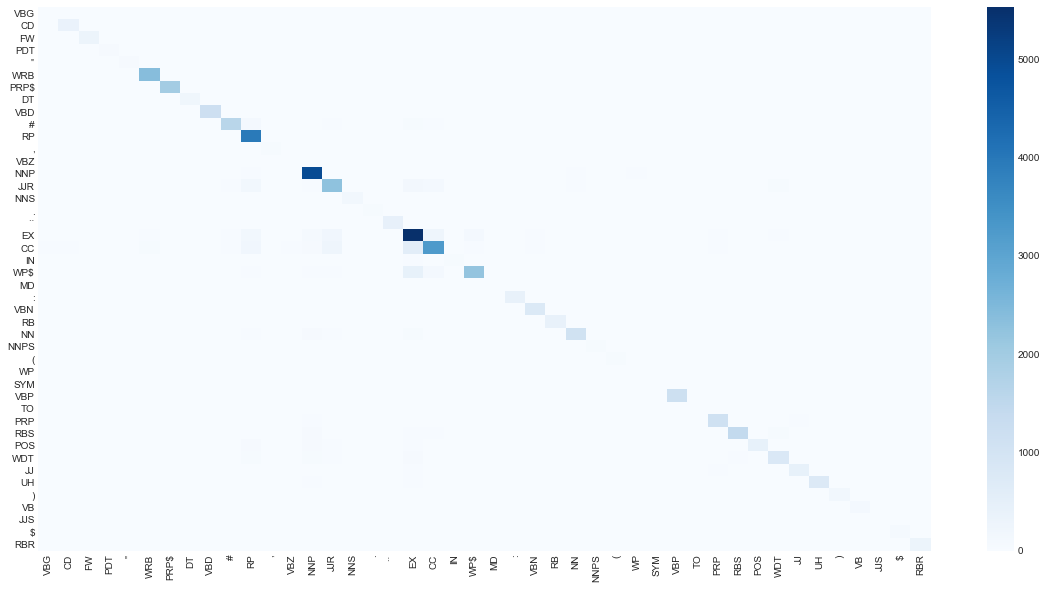

In [70]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (20,10))
sn.heatmap(df_conf,cmap='Blues')

In [80]:
#from client.api.notebook import Notebook
#ok = Notebook('a3.ok', mode="jupyterlab") 
#ok.auth(inline=True)